In [1]:
#Testing reductions serial version

In [35]:
import logging

import numpy
from mpi4py import MPI 

import astropy.units as u
from astropy.coordinates import SkyCoord

from data_models.polarisation import PolarisationFrame

from processing_library.image.operations import create_empty_image_like
from processing_components.image.operations import qa_image, show_image, export_image_to_fits
from processing_components.simulation.testing_support import create_test_image
from processing_components.image.gather_scatter import image_gather_facets, image_scatter_facets
from workflows.shared.imaging.imaging_shared import sum_invert_results_local, remove_sumwt
from matplotlib import pyplot as plt
from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

In [36]:
# Define a simple function to take the square root of an image
def imagerooter(image_list) -> list():
    new_image_list = []
    for im in image_list:
        newim = create_empty_image_like(im)
        newim.data = numpy.sqrt(numpy.abs(im.data))
        new_image_list.append(newim)
    return new_image_list


[[1.]]
[[1.]]
[[1.]]
[[1.]]
Quality assessment:
	Origin: qa_image
	Context: Model image
	Data:
		shape: '(1, 1, 256, 256)'
		max: '1.0064581632614136'
		min: '0.0'
		rms: '0.07250199656841093'
		sum: '1495.430664986372'
		medianabs: '0.0'
		median: '0.0'



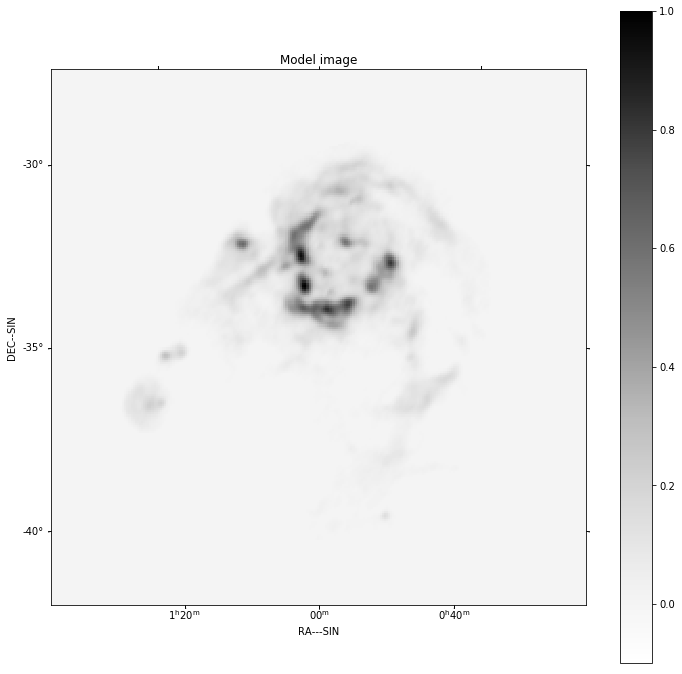

In [37]:
 # Create test images
num_images = 4
image_list=list()
for i in range(num_images):
    frequency = numpy.array([1e8])
    phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')
    model = create_test_image(frequency=frequency, phasecentre=phasecentre, cellsize=0.001,
                              polarisation_frame=PolarisationFrame('stokesI'))
    #print(model)
    nchan, npol, ny, nx = model.data.shape
    sumwt = numpy.ones([nchan, npol])
    print(sumwt)
    image_list.append((model,sumwt))

    if i==num_images-1:
        f=show_image(model, title='Model image', cm='Greys', vmax=1.0, vmin=-0.1)
        print(qa_image(model, context='Model image'))
        plt.show()



[[4.]]


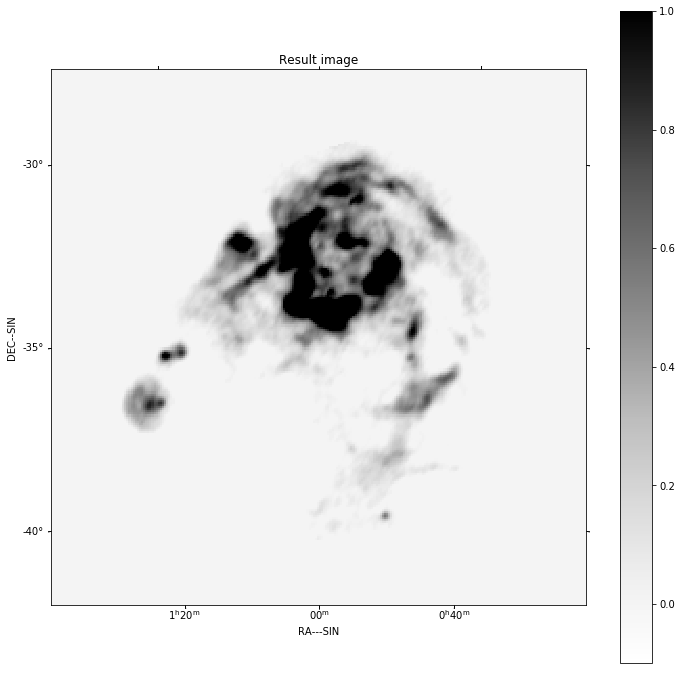

Quality assessment:
	Origin: qa_image
	Context: Result image
	Data:
		shape: '(1, 1, 256, 256)'
		max: '4.025832653045654'
		min: '0.0'
		rms: '0.2900079862736437'
		sum: '5981.722659945488'
		medianabs: '0.0'
		median: '0.0'



In [38]:
 # Accum images into one with weights 
(result_image,result_sumwt)=sum_invert_results_local(image_list)
print(result_sumwt)
f=show_image(result_image, title='Result image', cm='Greys', vmax=1.0, vmin=-0.1)
plt.show()
print(qa_image(result_image,context='Result image'))
# test correctness
assert(result_image.data.shape==model.data.shape)
numpy.testing.assert_array_almost_equal_nulp(result_image.data,
                                                 (model.data)*num_images, 7)
